In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import glob
import re

fns1 = glob.glob('/data/odc/derivatives/spynoza/sub-tk/ses-odc2/func/sub-tk_ses-odc2_task-*_acq-07_run-*_bold_confounds.tsv')
fns2 = glob.glob('/data/odc/derivatives/analysis_experiments/sub-tk/ses-odc2/func/*.tsv')
fns = fns1 + fns2

reg = re.compile('.*/sub-tk_ses-odc2_task-(?P<task>[a-z]+)_acq-07_run-(?P<run>[0-9]+)_(?P<type>.+).tsv')

In [3]:
df = pd.DataFrame()

for fn in fns:
    tmp = pd.read_table(fn).fillna(method='bfill')
    d = reg.match(fn).groupdict()
    for key, value in d.items():
        tmp[key] = value
    
    tmp['frame']= tmp.index
    
    df = pd.concat((df, tmp))
    
df['type'] = df.type.map({'bold_confounds':'FSL (normcorr)',
                          'bold_hmc_confounds':'FSL (mutual info)',
                          'bold_hmc_confounds_afni':'AFNI'})
df['run'] = df['run'].astype(int)

In [4]:
df = df.rename(columns={'X': 'X (mm)', 'Y':'Y (mm)', 'Z':'Z (mm)', 'RotX': 'RotX (rad)', 'RotY':'RotY (rad)', 'RotZ':'RotZ (rad)'})

In [5]:
sns.set_context('talk')

# Average framewise displacement per run

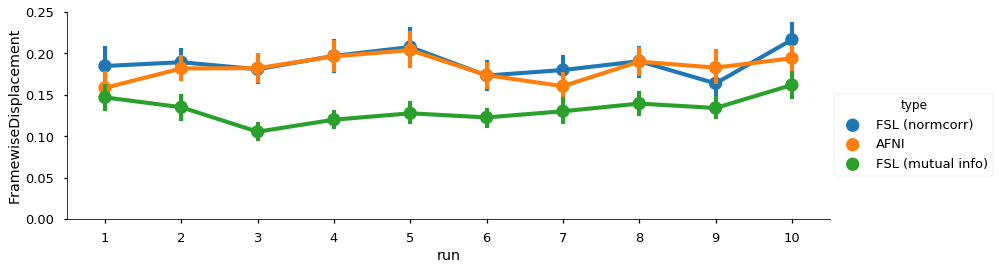

In [6]:
fac =sns.factorplot('run', 'FramewiseDisplacement', 'type', df, aspect=3,)
fac.set(ylim=(0, .25))

# Correlation of parameters across algorithms

In [19]:
tmp = df.melt(id_vars=['run', 'type', 'frame'], 
              value_vars=df.columns[:7]).pivot_table(index=['run', 'frame'], 
                                                     columns=['type', 'variable'], 
                                                     values='value').groupby('run').corr().abs()

tmp.index = tmp.index.set_names('var1', -1)
tmp.index = tmp.index.set_names('algorithm 1', -2)
tmp.columns = tmp.columns.set_names('var2', -1)
tmp = tmp.stack().reset_index(['var1', 'var2', 'algorithm 1'])
tmp = tmp.loc[tmp.var1 == tmp.var2].melt(id_vars=['algorithm 1', 'var1', 'var2']).drop(columns='var2').rename(columns={'type':'algorithm 2',
                                                                                                                      'var1':'variable'})

In [20]:
sns.set_style('whitegrid')

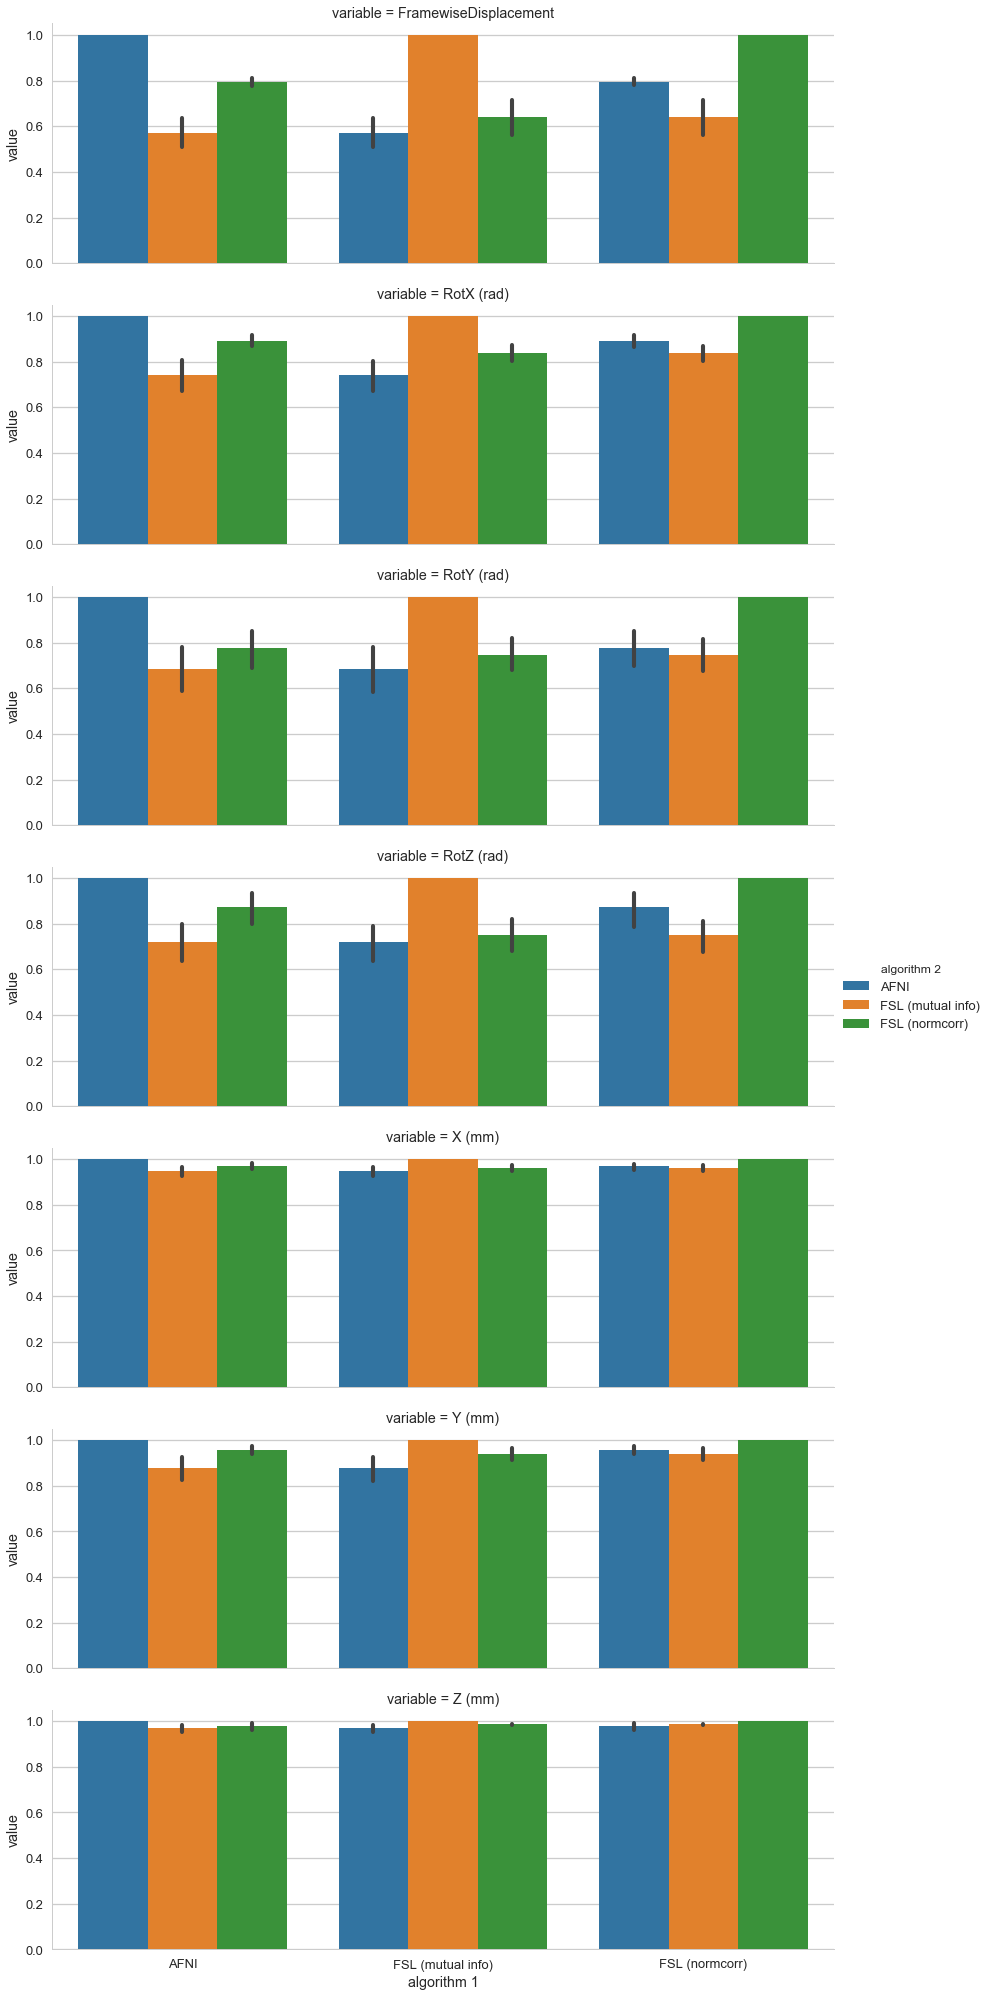

In [21]:
sns.factorplot('algorithm 1', 'value', 'algorithm 2', tmp, row='variable', aspect=3, kind='bar')

In [23]:
tmp = df.melt(id_vars=['run', 'type', 'frame'], 
              value_vars=df.columns[:7])

In [24]:
tmp['value_abs'] = tmp.groupby(['run', 'variable', 'type'])['value'].transform(lambda d: d - d.mean()).abs()

In [25]:
tmp['value_std'] = tmp.groupby(['run', 'variable', 'type'])['value_abs'].transform(lambda d: d - d.mean()).abs()
tmp['value_range'] = tmp.groupby(['run', 'variable', 'type'])['value_abs'].transform(lambda d: d.max() - d.min())

# Absolute deviance per frame

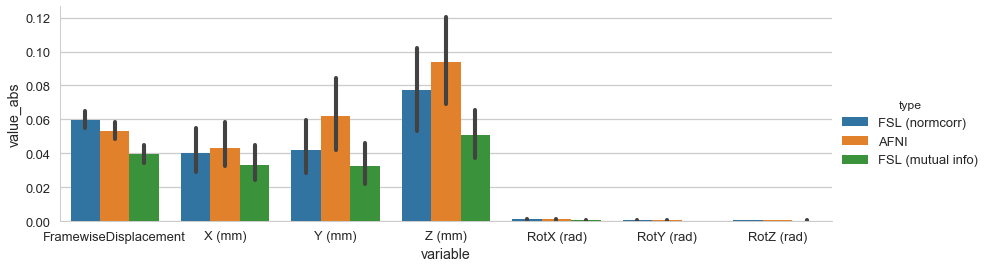

In [26]:
sns.factorplot('variable', 'value_abs', 'type', tmp, units='run', aspect=3, kind='bar')

# Standard deviation over a whole run

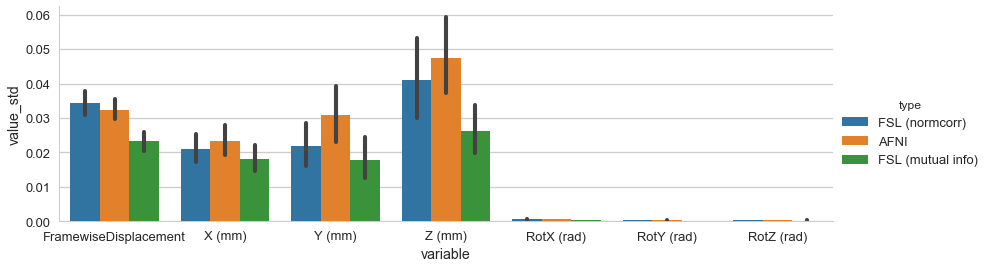

In [27]:
sns.factorplot('variable', 'value_std', 'type', tmp, units='run', aspect=3, kind='bar')

# Range deviation over a whole run

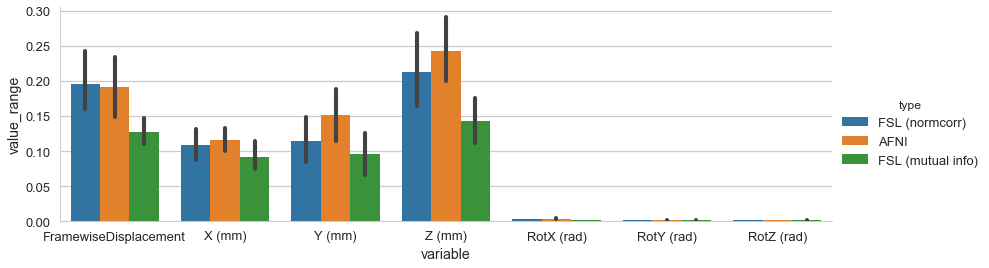

In [29]:
sns.factorplot('variable', 'value_range', 'type', tmp, units='run', aspect=3, kind='bar')

In [ ]:
tmp = df.melt(id_vars=['run', 'type', 'frame'], 
              value_vars=df.columns[:7])

In [15]:
keys = df.columns[:7]

In [16]:
def plot_df(data,color):
    data[keys].plot(ax=plt.gca())

# Plot of all estimated movement parameters

Note that the estimated y-parameter for AFNI is flipped compared to FSL

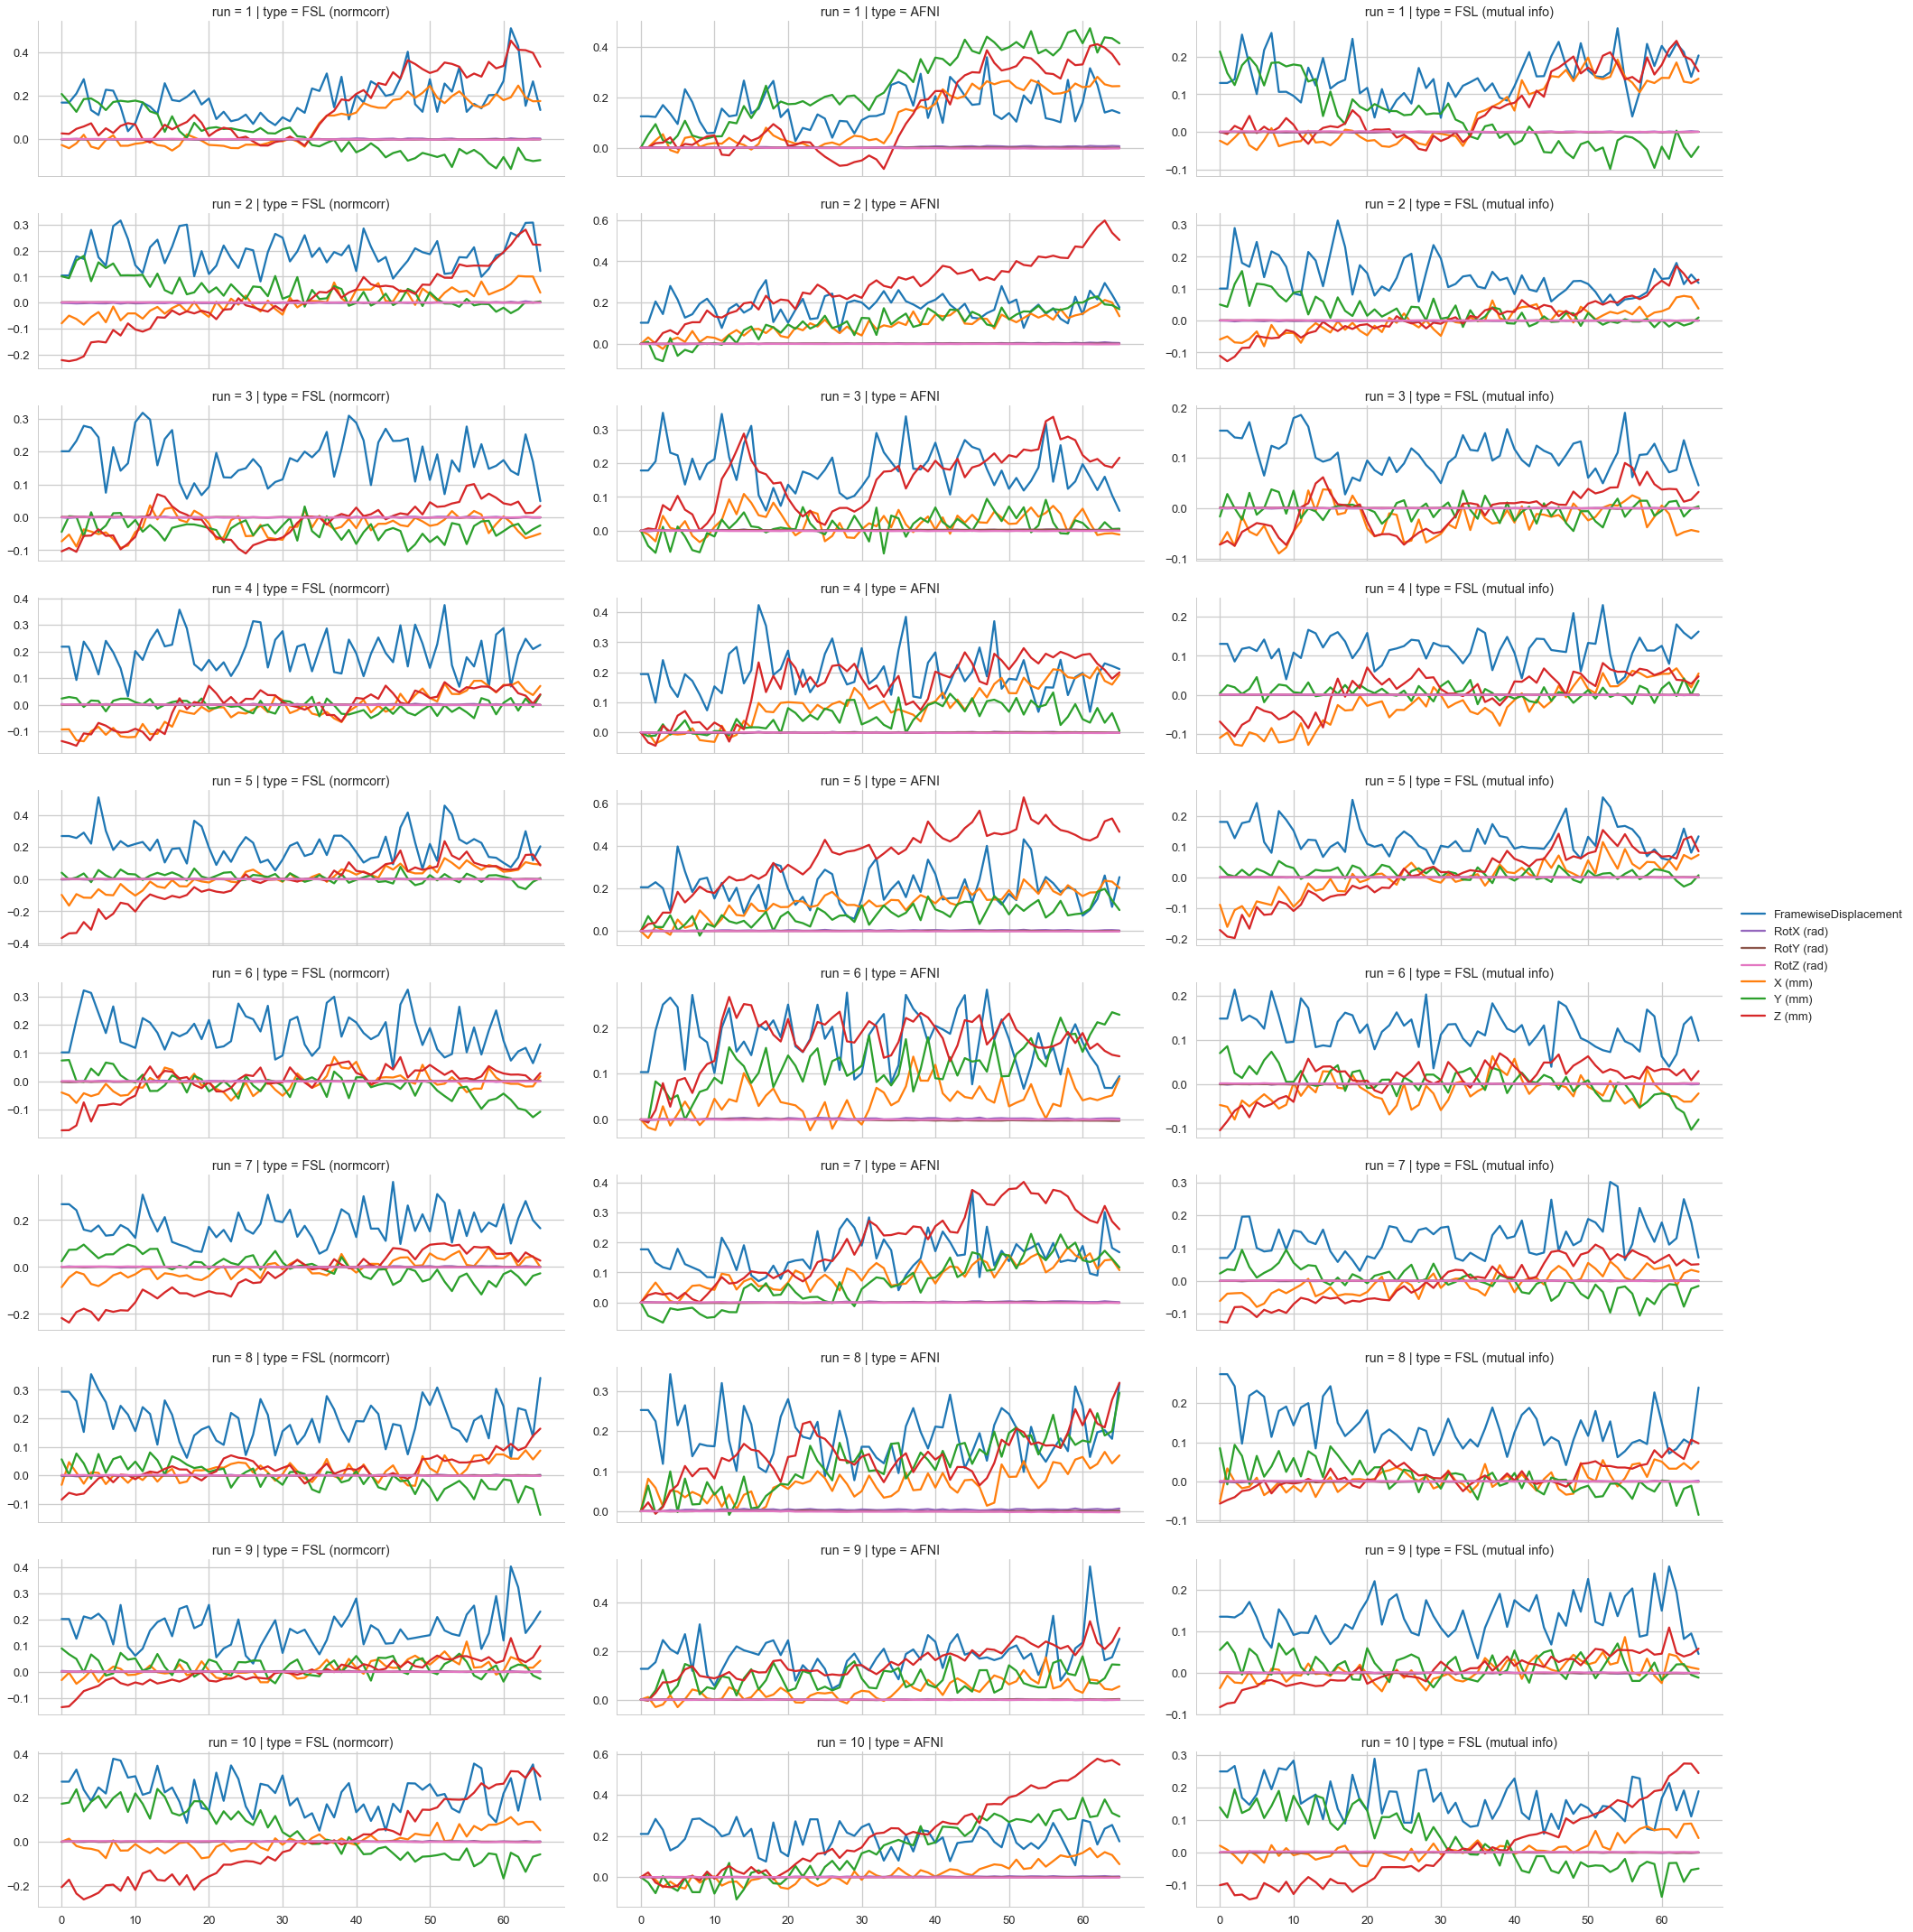

In [17]:
fac = sns.FacetGrid(df, col='type', row='run', aspect=3, sharey=False)

fac.map_dataframe(plot_df).add_legend()